In [1]:
from datasets import load_dataset

ds = load_dataset("luigi-s/EEG_Image_CVPR_ALL_subj")

c:\Users\prans\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ds["train"].features

{'image': Image(mode=None, decode=True, id=None),
 'conditioning_image': Array2D(shape=(128, 440), dtype='float32', id=None),
 'caption': Value(dtype='string', id=None),
 'label_folder': Value(dtype='string', id=None),
 'label': Value(dtype='int32', id=None),
 'subject': Value(dtype='int32', id=None)}

In [10]:
ds_train = ds["train"]
ds_valid = ds["validation"]
ds_test = ds["test"]

In [17]:
# show the image
import matplotlib.pyplot as plt

len(ds['train'][0]['conditioning_image'])
print(len(ds['train'][0]['conditioning_image'][0]) , len(ds['train'][0]['conditioning_image']))

440 128


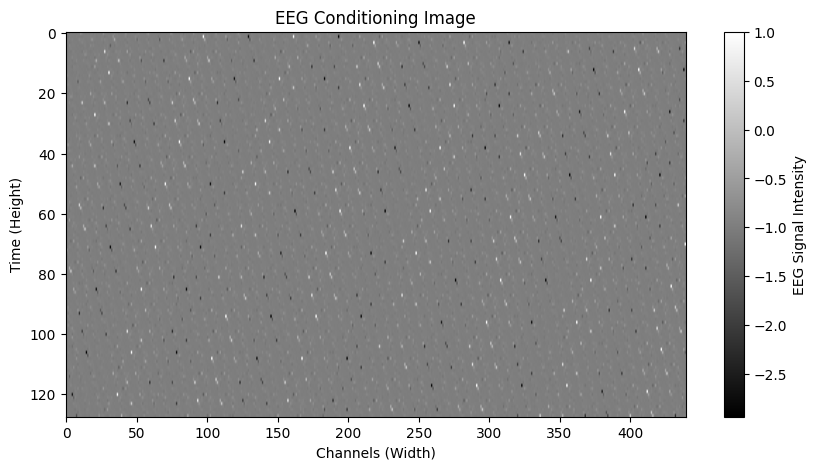

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Extract conditioning image from dataset
conditioning_image = ds['train'][0]['conditioning_image']  # Shape (H, W)

# Convert to NumPy array (if not already)
conditioning_image = np.array(conditioning_image)

# Plot the EEG signal as an image
plt.figure(figsize=(10, 5))
plt.imshow(conditioning_image, cmap='gray', aspect='auto')
plt.colorbar(label="EEG Signal Intensity")
plt.title("EEG Conditioning Image")
plt.xlabel("Channels (Width)")
plt.ylabel("Time (Height)")
plt.show()

In [6]:
import numpy as np
from scipy.signal import butter, filtfilt


def bandpass_filter(data, lowcut=1.0, highcut=50.0, fs=250, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data, axis=0)


def apply_filter_to_record(example):
    eeg_array = np.array(example['conditioning_image'])
    filtered_eeg = bandpass_filter(
        eeg_array, lowcut=1.0, highcut=50.0, fs=250, order=4)
    example['conditioning_image'] = filtered_eeg.tolist()
    return example


ds_train_filtered = ds_train.map(apply_filter_to_record)

In [25]:
ds_train_filtered[0]['conditioning_image']

[[-0.0026539659593254328,
  0.0014708592789247632,
  -0.013569173403084278,
  -0.006416902411729097,
  -0.01994745433330536,
  0.011206431314349174,
  4.9417332775192335e-05,
  -0.05467024818062782,
  -0.007678074762225151,
  -0.02112850546836853,
  -0.005510145798325539,
  -0.008161637932062149,
  -0.009928536601364613,
  0.004759113769978285,
  0.035080987960100174,
  0.008651278913021088,
  -0.014176652766764164,
  0.0013710615457966924,
  -0.007923089899122715,
  -0.004745164420455694,
  0.49571493268013,
  0.0023089381866157055,
  -0.012142583727836609,
  0.053328968584537506,
  -0.0025584003888070583,
  -0.011837232857942581,
  0.01611568219959736,
  -0.005935939494520426,
  0.009726724587380886,
  0.015642713755369186,
  -0.01612536422908306,
  0.03237579017877579,
  -0.015846533700823784,
  -0.04817790538072586,
  -0.0005463878624141216,
  0.05658400058746338,
  0.006446192041039467,
  -0.015751922503113747,
  0.016214337199926376,
  0.06776466965675354,
  -0.002300736028701067

In [ ]:
import numpy as np

# drop the columns label_folder , label , subject

ds_train_filtered = ds_train_filtered.remove_columns(
    ['label_folder', 'label', 'subject'])
ds_valid = ds_valid.remove_columns(['label_folder', 'label', 'subject'])
ds_test = ds_test.remove_columns(['label_folder', 'label', 'subject'])

In [26]:
import numpy as np

# Extract conditioning image from dataset
conditioning_image = np.array(ds['train'][0]['conditioning_image'])

# Print shape to confirm dimensions
print("Conditioning Image Shape:", conditioning_image.shape)

# Pick a channel and inspect values
channel_index = 0  # Modify if needed
eeg_signal = conditioning_image[channel_index]

print("EEG Signal Sample:", eeg_signal[:10])  # Print first 10 values

Conditioning Image Shape: (128, 440)
EEG Signal Sample: [-1.00429785 -0.9780193  -1.0273838  -0.95659113 -0.98452753 -0.99355316
 -0.97955424 -0.99944741 -0.9545036  -0.95376682]


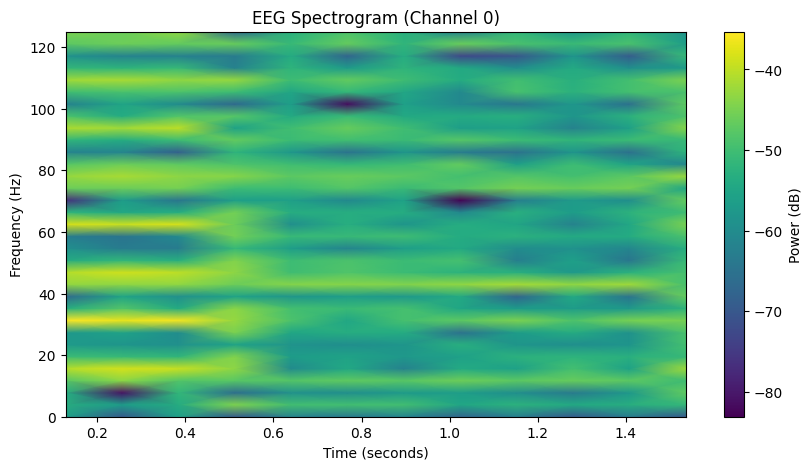

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram

# Extract the EEG signal (You can try different channels)
channel_index = 0
eeg_signal = conditioning_image[channel_index]  # Shape: (440,)

# Spectrogram parameters
fs = 250  # Sampling frequency (modify if needed)

# Compute the spectrogram
frequencies, times, Sxx = spectrogram(
    eeg_signal, fs=fs, nperseg=64, noverlap=32)

# Plot the spectrogram
plt.figure(figsize=(10, 5))
plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx),
               shading='gouraud', cmap='viridis')
plt.colorbar(label='Power (dB)')
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency (Hz)')
plt.title(f'EEG Spectrogram (Channel {channel_index})')
plt.show()

In [67]:
ds_train_filtered = ds_train_filtered.remove_columns(['image_features'])

Map: 100%|██████████| 7959/7959 [08:31<00:00, 15.55 examples/s]  


Image 0 Features Shape: (150528,)


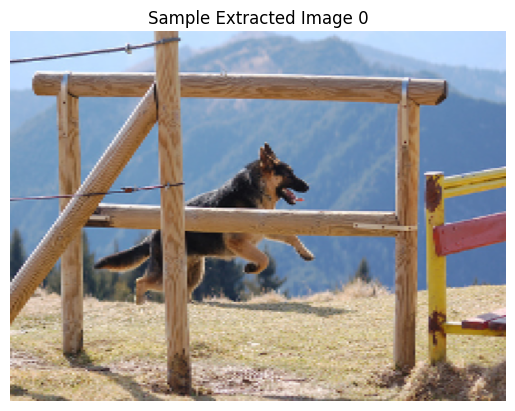

Image 1 Features Shape: (150528,)


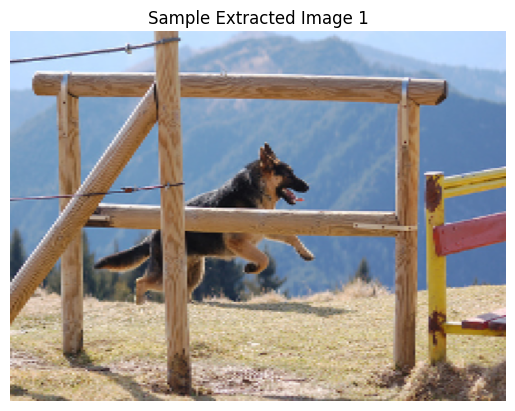

Image 2 Features Shape: (150528,)


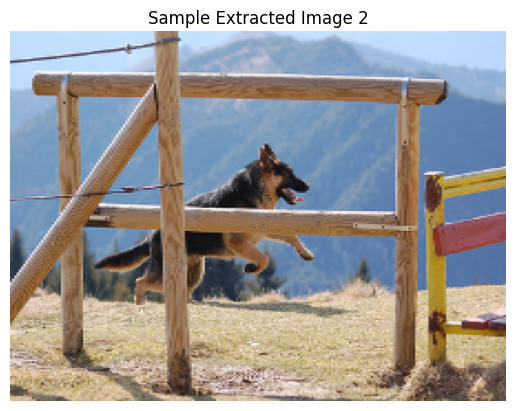

In [68]:
import numpy as np
import matplotlib.pyplot as plt
from datasets import Dataset


def add_image_features(ds, normalize=True):
    """
    Extracts images from a Hugging Face dataset, converts them to NumPy arrays, 
    normalizes (optional), flattens, and adds them as a new feature column.

    Args:
        ds (datasets.Dataset): The Hugging Face dataset.
        normalize (bool): Whether to normalize pixel values between 0 and 1.

    Returns:
        datasets.Dataset: Updated dataset with "image_features" column.
    """

    # Function to process each row
    def process_image(example):
        image = np.array(example['image'])  # Extract image
        if normalize:
            image = image.astype(np.float32) / 255.0  # Normalize
        return {"image_features": image.flatten()}  # Flatten and return

    # Apply function to entire dataset without modifying structure
    ds = ds.map(process_image)

    # Verify by checking a few samples
    for i in range(3):  # Check the first 3 images
        print(f"Image {i} Features Shape:", np.array(
            ds[i]['image_features']).shape)

        plt.imshow(np.array(ds[i]['image']), cmap='gray', aspect='auto')
        plt.title(f"Sample Extracted Image {i}")
        plt.axis("off")
        plt.show()

    return ds


# Usage:
ds_train_filtered = add_image_features(ds_train_filtered)

In [71]:
ds_train_filtered[34]["image_features"]

[0.4901960790157318,
 0.4901960790157318,
 0.572549045085907,
 0.5215686559677124,
 0.545098066329956,
 0.6745098233222961,
 0.5843137502670288,
 0.6196078658103943,
 0.686274528503418,
 0.5843137502670288,
 0.6274510025978088,
 0.7843137383460999,
 0.6078431606292725,
 0.6745098233222961,
 0.772549033164978,
 0.5411764979362488,
 0.615686297416687,
 0.6901960968971252,
 0.46666666865348816,
 0.5529412031173706,
 0.5686274766921997,
 0.40392157435417175,
 0.48627451062202454,
 0.5333333611488342,
 0.4588235318660736,
 0.5490196347236633,
 0.6196078658103943,
 0.48235294222831726,
 0.5764706134796143,
 0.6274510025978088,
 0.5254902243614197,
 0.5960784554481506,
 0.6705882549285889,
 0.5098039507865906,
 0.572549045085907,
 0.6705882549285889,
 0.43529412150382996,
 0.5058823823928833,
 0.529411792755127,
 0.30588236451148987,
 0.3686274588108063,
 0.3803921639919281,
 0.3843137323856354,
 0.45490196347236633,
 0.5568627715110779,
 0.5372549295425415,
 0.6000000238418579,
 0.7294117808

In [77]:

# rename the column conditioning_image to eeg_signal

# ds_train_filtered = ds_train_filtered.rename_column('conditioning_image', 'eeg_signal')
ds_train_filtered.features

{'image': Image(mode=None, decode=True, id=None),
 'eeg_signal': Array2D(shape=(128, 440), dtype='float32', id=None),
 'caption': Value(dtype='string', id=None),
 'image_features': Sequence(feature=Value(dtype='float32', id=None), length=-1, id=None)}

In [83]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer

# 🔹 Custom EEG Dataset


class EEGDataset(Dataset):
    def __init__(self, dataset, tokenizer, max_len=50):
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        eeg_signal = torch.tensor(
            self.dataset[idx]['eeg_signal'], dtype=torch.float32)

        caption_tokens = self.tokenizer(
            self.dataset[idx]['caption'],
            padding='max_length',
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt"
        )['input_ids'].squeeze(0)

        return eeg_signal, caption_tokens

# 🔹 EEG Encoder (CNN + Bi-LSTM + Projection Layer)


class EEGEncoder(nn.Module):
    def __init__(self):
        super(EEGEncoder, self).__init__()
        self.conv1 = nn.Conv1d(
            in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv1d(64, 32, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.lstm = nn.LSTM(input_size=32, hidden_size=128,
                            num_layers=2, batch_first=True)

        # **Projection Layer to Match Decoder Input Size**
        self.fc = nn.Linear(128, 256)  # Project 128 → 256

    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        x, _ = self.lstm(x.permute(0, 2, 1))  # (batch, seq_len, feature)
        x = self.fc(x[:, -1, :])  # Project to 256 dimensions
        return x

# 🔹 Caption Decoder (Transformer)


class CaptionDecoder(nn.Module):
    def __init__(self, vocab_size, embed_dim=256, hidden_dim=128, num_heads=4, num_layers=3):
        super(CaptionDecoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.transformer_decoder = nn.TransformerDecoder(
            nn.TransformerDecoderLayer(d_model=embed_dim, nhead=num_heads),
            num_layers=num_layers
        )
        self.fc = nn.Linear(embed_dim, vocab_size)

    def forward(self, eeg_features, captions):
        caption_embeddings = self.embedding(captions)

        # Ensure eeg_features is properly expanded to match the sequence length
        eeg_features = eeg_features.unsqueeze(
            0).repeat(caption_embeddings.size(0), 1, 1)

        output = self.transformer_decoder(caption_embeddings, eeg_features)
        return self.fc(output)

# 🔹 EEG2Caption Model (Combining Encoder & Decoder)


class EEG2Caption(nn.Module):
    def __init__(self, vocab_size):
        super(EEG2Caption, self).__init__()
        self.encoder = EEGEncoder()
        self.decoder = CaptionDecoder(vocab_size)

    def forward(self, eeg_signal, captions):
        eeg_features = self.encoder(eeg_signal)
        caption_outputs = self.decoder(eeg_features, captions)
        return caption_outputs

# 🔹 Training Function


def train_model(model, train_loader, criterion, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for eeg_signal, captions in train_loader:
            eeg_signal, captions = eeg_signal.to(device), captions.to(device)

            optimizer.zero_grad()
            outputs = model(eeg_signal, captions[:, :-1])  # Predict next word

            loss = criterion(
                outputs.reshape(-1, outputs.shape[-1]), captions[:, 1:].reshape(-1))
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_loader)}")


# 🔹 Load Data and Train
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Create Dataset & DataLoader
dataset = EEGDataset(ds_train_filtered, tokenizer)
train_loader = DataLoader(dataset, batch_size=16, shuffle=True)

# Initialize Model
vocab_size = tokenizer.vocab_size
model = EEG2Caption(vocab_size).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
train_model(model, train_loader, criterion, optimizer, epochs=5)

RuntimeError: shape '[16, 196, 64]' is invalid for input of size 65536